In [80]:
import mujoco
import mujoco.viewer
import numpy as np
import matplotlib.pyplot as plt
from mujoco_parser import MuJoCoParserClass
import os
import mediapy as media
import cv2
from datetime import datetime
import time
from threading import Thread, Lock
import roboticstoolbox as rtb
from scipy.spatial.transform import Rotation as R
import spatialmath as sm
import re

scene_path = '../../asset/mujoco/ur5e/scene_ur5e_test.xml'
env = MuJoCoParserClass(name='UR5e',rel_xml_path=scene_path,USE_MUJOCO_VIEWER=False,VERBOSE=True)

dt:[0.0020] HZ:[500]
n_dof (=nv):[6]
n_geom:[32]
geom_names:['floor', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
n_body:[9]
body_names:['world', 'base', 'shoulder_link', 'upper_arm_link', 'forearm_link', 'wrist_1_link', 'wrist_2_link', 'wrist_3_link', 'eef_tool']
n_joint:[6]
joint_names:['shoulder_pan_joint', 'shoulder_lift_joint', 'elbow_joint', 'wrist_1_joint', 'wrist_2_joint', 'wrist_3_joint']
joint_types:[3 3 3 3 3 3]
joint_ranges:
[[-6.28319  6.28319]
 [-6.28319  6.28319]
 [-3.1415   3.1415 ]
 [-6.28319  6.28319]
 [-6.28319  6.28319]
 [-6.28319  6.28319]]
n_rev_joint:[6]
rev_joint_idxs:[0 1 2 3 4 5]
rev_joint_names:['shoulder_pan_joint', 'shoulder_lift_joint', 'elbow_joint', 'wrist_1_joint', 'wrist_2_joint', 'wrist_3_joint']
rev_joint_mins:[-6.28319 -6.28319 -3.1415  -6.28319 -6.28319 -6.28319]
rev_joint_maxs:[6.28319 6.28319 3.1415  6.2831

In [81]:
import cv2
from matplotlib import image
import cv2.aruco
import numpy as np


def toTransformMatrix(rvec, tvec):
    rotmat, Jc = cv2.Rodrigues(rvec)
    tmat = np.identity(4)
    tmat[0:3, 0:3] = rotmat
    tmat[0:3, 3] = np.squeeze(tvec)
    return tmat


def trackMarker(img, cameraMatrix, markerLength, showImage=False, bw=True):
    dictionary = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_6X6_250)
    parameters = cv2.aruco.DetectorParameters()
    detector = cv2.aruco.ArucoDetector(dictionary, parameters)
    camTmarker = None


    if (bw):
        dst = cv2.equalizeHist(img) # only for bw images. If rgb image, remove this line.
    else:
        dst = img

    
    corners, ids, rejected_points = detector.detectMarkers(img)


    distCoeffs = np.zeros(4)

    rvecs, tvecs, objpoints = cv2.aruco.estimatePoseSingleMarkers(
        corners, markerLength, cameraMatrix, distCoeffs)
    
    if tvecs is not None:
        camTmarker = toTransformMatrix(rvecs[0], tvecs[0])

        if camTmarker[2, 2] > 0:
            camTmarker[:, 2] *= -1

        if showImage:
            cv2.drawFrameAxes(dst, cameraMatrix, distCoeffs,
                            rvecs[0], tvecs[0], 0.05)
            

            
    cv2.imshow("Aruco", dst)

    return camTmarker

def transformToBaseFrame(camTmarker, baseTcam):
    """Transform the marker's pose from the camera frame to the robot's base frame."""
    if camTmarker is None:
        return None
    return baseTcam @ camTmarker

def extractPose(transformMatrix):
    """Extract position and orientation (roll, pitch, yaw) from the transformation matrix."""
    position = transformMatrix[0:3, 3]
    rotation_matrix = transformMatrix[0:3, 0:3]
    rotation = R.from_matrix(rotation_matrix)
    rpy = rotation.as_euler('xyz', degrees=False)  # Roll, Pitch, Yaw
    pose = np.concatenate((position, rpy))
    return pose

In [82]:
class PID_ControllerClass(object):
    def __init__(self,
                 name      = 'PID',
                 k_p       = 0.01,
                 k_i       = 0.0,
                 k_d       = 0.001,
                 dt        = 0.01,
                 dim       = 1,
                 dt_min    = 1e-6,
                 out_min   = -np.inf,
                 out_max   = np.inf,
                 ANTIWU    = True,   # anti-windup
                 out_alpha = 0.0    # output EMA (0: no EMA)
                ):
        """
            Initialize PID Controller
        """
        self.name      = name
        self.k_p       = k_p
        self.k_i       = k_i
        self.k_d       = k_d
        self.dt        = dt
        self.dim       = dim
        self.dt_min    = dt_min
        self.out_min   = out_min
        self.out_max   = out_max
        self.ANTIWU    = ANTIWU
        self.out_alpha = out_alpha
        # Buffers
        self.cnt      = 0
        self.x_trgt   = np.zeros(shape=self.dim)
        self.x_curr   = np.zeros(shape=self.dim)
        self.out_val  = np.zeros(shape=self.dim)
        self.out_val_prev = np.zeros(shape=self.dim)
        self.t_curr   = 0.0
        self.t_prev   = 0.0
        self.err_curr = np.zeros(shape=self.dim)
        self.err_intg = np.zeros(shape=self.dim)
        self.err_prev = np.zeros(shape=self.dim)
        self.p_term   = np.zeros(shape=self.dim)
        self.d_term   = np.zeros(shape=self.dim)
        self.err_out  = np.zeros(shape=self.dim)
        
    def reset(self,t_curr=0.0):
        """
            Reset PID Controller
        """
        self.cnt      = 0
        self.x_trgt   = np.zeros(shape=self.dim)
        self.x_curr   = np.zeros(shape=self.dim)
        self.out_val  = np.zeros(shape=self.dim)
        self.out_val_prev = np.zeros(shape=self.dim)
        self.t_curr   = t_curr
        self.t_prev   = t_curr
        self.err_curr = np.zeros(shape=self.dim)
        self.err_intg = np.zeros(shape=self.dim)
        self.err_prev = np.zeros(shape=self.dim)
        self.p_term   = np.zeros(shape=self.dim)
        self.d_term   = np.zeros(shape=self.dim)
        self.err_out  = np.zeros(shape=self.dim)
        
    def update(
        self,
        t_curr  = None,
        x_trgt  = None,
        x_curr  = None,
        VERBOSE = True
        ):
        """
            Update PID controller
            u(t) = K_p e(t) + K_i int e(t) {dt} + K_d {de}/{dt}
        """
        if x_trgt is not None:
            self.x_trgt  = x_trgt
        if t_curr is not None:
            self.t_curr  = t_curr
        if x_curr is not None:
            self.x_curr  = x_curr
            # PID controller updates here
            self.dt       = max(self.t_curr - self.t_prev,self.dt_min)
            self.err_curr = self.x_trgt - self.x_curr     
            self.err_intg = self.err_intg + (self.err_curr*self.dt)
            self.err_diff = self.err_curr - self.err_prev
            
            if self.ANTIWU: # anti-windup
                self.err_out = self.err_curr * self.out_val
                self.err_intg[self.err_out<0.0] = 0.0
            
            if self.dt > self.dt_min:
                self.p_term   = self.k_p * self.err_curr
                self.i_term   = self.k_i * self.err_intg
                self.d_term   = self.k_d * self.err_diff / self.dt
                self.out_val  = np.clip(
                    a     = self.p_term + self.i_term + self.d_term,
                    a_min = self.out_min,
                    a_max = self.out_max)
                # Smooth the output control value using EMA
                self.out_val = self.out_alpha*self.out_val_prev + \
                    (1.0-self.out_alpha)*self.out_val
                self.out_val_prev = self.out_val

                if VERBOSE:
                    print ("cnt:[%d] t_curr:[%.5f] dt:[%.5f]"%
                           (self.cnt,self.t_curr,self.dt))
                    print (" x_trgt:   %s"%(self.x_trgt))
                    print (" x_curr:   %s"%(self.x_curr))
                    print (" err_curr: %s"%(self.err_curr))
                    print (" err_intg: %s"%(self.err_intg))
                    print (" p_term:   %s"%(self.p_term))
                    print (" i_term:   %s"%(self.i_term))
                    print (" d_term:   %s"%(self.d_term))
                    print (" out_val:  %s"%(self.out_val))
                    print (" err_out:  %s"%(self.err_out))
            # Backup
            self.t_prev   = self.t_curr
            self.err_prev = self.err_curr
        # Counter
        if (t_curr is not None) and (x_curr is not None):
            self.cnt = self.cnt + 1
            
    def out(self):
        """
            Get control output
        """
        return self.out_val

In [83]:
PID = PID_ControllerClass(
    name = 'PID',dim = env.n_rev_joint,
    k_p = 2000, #1000, 
    k_i = 500, 
    k_d = 0, 
    out_min = env.ctrl_ranges[env.rev_joint_idxs,0],
    out_max = env.ctrl_ranges[env.rev_joint_idxs,1],
    ANTIWU  = True)

In [84]:
# bah = 8
# print(env.body_names[bah])	
# env.print_transform(env.body_names[bah])

In [85]:
#################
#Must have
env.init_viewer(viewer_title='Spawn Objects',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=90,distance=2,elevation=-20,lookat=[0.2,0,0.2])
env.update_viewer(VIS_TRANSPARENT=True) # transparent
env.reset()
PID.reset()
#############

init_q =[-1.0, -0.957187, 1.19558, -1.78486, -1.56677, -0.00717087]
env.set_initial_qpos(init_q)


# Buffers
max_tick    = 600
seconds     = max_tick/100

######################
#To make plots
sec_list    = np.zeros(shape=max_tick)
q_list      = np.zeros(shape=(max_tick,env.n_rev_joint))
q_des_list  = np.zeros(shape=(max_tick,PID.dim))
torque_list = np.zeros(shape=(max_tick,env.n_rev_joint))
scene_list = []
####################


markerLength = 0.038
cameraMatrix = np.load('./camera/mtx.npy')

cap = cv2.VideoCapture(0) #pc cam = 0 || external cam = 2
if not cap.isOpened():
    print("Cannot open camera")
    exit()

#Base transform
baseTcam = np.array([[1, 0, 0, 0],
                     [0, 1, 0, 0],
                     [0, 0, 1, 0],
                     [0, 0, 0, 1]])
tool_matrix = sm.SE3.Trans(0., 0., 0.05)
robot_base = sm.SE3.Trans(0,0,0)

robot = rtb.DHRobot(
            [ 
                rtb.RevoluteDH(d=0.163, alpha = np.pi/2),
                rtb.RevoluteDH(a=-0.425),
                rtb.RevoluteDH(a=-0.392),
                rtb.RevoluteDH(d=0.127, alpha=np.pi/2),
                rtb.RevoluteDH(d=0.1, alpha=-np.pi/2),
                rtb.RevoluteDH(d=0.1)
            ], name="UR5e",
            base=robot_base,
            tool = tool_matrix,
            )
robot.q = init_q
initial_pose = robot.fkine(robot.q).A
#print(initial_pose)
init_z = initial_pose[2, 3] #storing the initial position of the end-effector along the z-axis 

# Low-pass filter parameters
alpha = 0.01  # Smoothing factor for the low-pass filter
filtered_joint_pose = None
filtered_cartesian_pose = None

def desired_joint_positions(T, t, init_pose):
    omega = 2 * np.pi / T
    amplitude = 0.1
    offset = np.array(init_pose)  # Initial joint positions
    return offset + amplitude * np.sin(omega * t)

def clamp(value, minimum, maximum):
    return max(minimum, min(value, maximum))

filtered_joint_pose = np.array(init_q)
q_des = init_q

while env.tick < max_tick and env.is_viewer_alive(): #Run code loop
    # Capture frame-by-frame
    ret, frame = cap.read(0)

    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break
    
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    camTmarker = trackMarker(gray, cameraMatrix, markerLength, True)
    #print(camTmarker)
    if camTmarker is None:
        q_des = q_des
    else:
    
        cartesian_pose = extractPose(camTmarker)
        # Clamp x, y, z values within the desired range
        cartesian_pose[0] = clamp(cartesian_pose[0], -0.2, 0.2)  # Clamping x
        cartesian_pose[1] = clamp(cartesian_pose[1], -0.2, 0.2)  # Clamping y
        cartesian_pose[2] = clamp(cartesian_pose[2], -0.2, 0.2)  # Clamping z
        cartesian_pose[-3:] = 0 # force rotation (rpy) to be 0
        #filter cartesian
        # if filtered_cartesian_pose is None:
        #     filtered_cartesian_pose = cartesian_pose
        # else:
        #     filtered_cartesian_pose = alpha * cartesian_pose + (1 - alpha) * filtered_cartesian_pose
        #print("car pose: ",cartesian_pose)
        Tep = robot.fkine(cartesian_pose)
        #print("tep : ", Tep)
        joint_pose = robot.ik_LM(Tep)
        joint_pose = joint_pose[0]
        #print("joint pose : ", joint_pose)
        # Apply low-pass filter to the joint_pose
        filtered_joint_pose = alpha * joint_pose + (1 - alpha) * filtered_joint_pose
        #t = env.tick / 100
        q_des = filtered_joint_pose# desired_joint_positions(seconds, t, init_q)
        #print("Desired pose : ", q_des)


    # PID control
    PID.update(x_trgt=q_des)
    PID.update(t_curr=env.get_sim_time(),x_curr=env.get_q(joint_idxs=env.rev_joint_idxs),VERBOSE=False)
    torque = PID.out()
    env.step(ctrl=torque,ctrl_idxs=env.rev_joint_idxs)


    #everything below is for plotting    
    sec_list[env.tick-1]      = env.get_sim_time()
    q_list[env.tick-1,:]      = env.get_q(joint_idxs=env.rev_joint_idxs)    
    q_des_list[env.tick-1,:]  = q_des
    torque_list[env.tick-1,:] = torque

    ##########
    #####################
    #DO NOT DELETE 
    #Disable this for no viewer
    if (env.tick % 1) == 0:
        env.render()
        scene_img = env.grab_image()
        scene_list.append(scene_img)
    ###########

    key = cv2.waitKey(1) & 0xFF
    if key == ord("q"):
        break
            
#################
#Must have
cv2.destroyAllWindows()
cap.release()    
env.close_viewer() 
#############

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


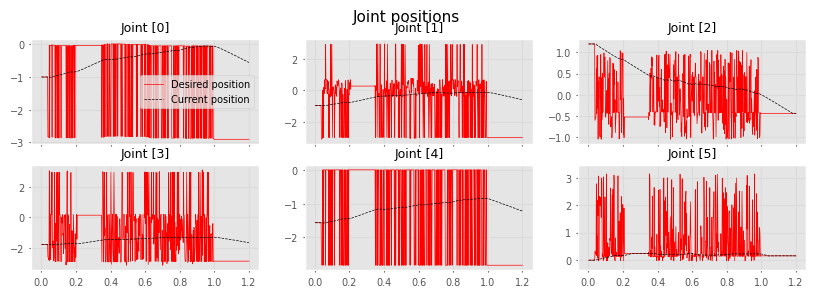

In [86]:
# Plot joint positions
fig, axs = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=False, figsize=(10, 3))
fig.suptitle("Joint positions", fontsize=11)

# Set margins for all subplots
plt.margins(y=0.1)

# Iterate over subplots
for a_idx, ax in enumerate(axs.ravel()):
    # Skip if the subplot index exceeds the dimensions
    if a_idx >= PID.dim:
        continue
    
    # Plot desired and current positions
    ax.plot(sec_list, q_des_list[:, a_idx], '-', color='r', label='Desired position')
    ax.plot(sec_list, q_list[:, a_idx], '--', color='k', label='Current position')
    
    # Set subplot title
    ax.set_title('Joint [%d]' % (a_idx), fontsize=9)
    
    # Add legend only to the first subplot
    if a_idx == 0:
        ax.legend(fontsize=7)

plt.savefig('joint_positions_sinewave.eps', format='eps')

plt.show()

# # Plot joint torques
# fig,axs = plt.subplots(nrows=2,ncols=3,sharex=True,sharey=False,figsize=(10,3))
# fig.suptitle("Joint torques", fontsize=11)

# # Set margins for all subplots
# plt.margins(y=0.1)

# for a_idx,ax in enumerate(axs.ravel()):
#     if (a_idx >= PID.dim): continue

#     ax.plot(sec_list,torque_list[:,a_idx],'-',color='k',label='',lw=1)
#     ax.set_title('Joint [%d]'%(a_idx),fontsize=9)
# plt.show()

In [87]:
capture_mode = 0
if capture_mode == 1:
    #folder_path = '..\\..\\data\\videos\\'
    # Get the current date and time
    now = datetime.now()
    # Format the date and time as a string
    date_time_str = now.strftime("%d-%m-%Y_%H:%M:%S")

    video_name = f"video_{date_time_str}.avi"

    frame = scene_list[0]
    height, width, layers = frame.shape

    video = cv2.VideoWriter(video_name, 0, 60, (width,height))

    for image in scene_list:
        video.write(image)

    cv2.destroyAllWindows()
    video.release()